In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
file_list = os.listdir("/works/Data/Dacon/health_data_clf/")
file_list = [file for file in file_list if file.endswith(".csv")]
print(file_list)

['train_labels.csv', 'test_features.csv', 'train_features.csv', 'sample_submission.csv']


In [3]:
file_path = "/works/Data/Dacon/health_data_clf/"
train_label = pd.read_csv(file_path + file_list[0])
test_features = pd.read_csv(file_path + file_list[1])
train_features = pd.read_csv(file_path + file_list[2])
sample_submissuib = pd.read_csv(file_path + file_list[3])

print(train_label.shape)
print(test_features.shape)
print(train_features.shape)

(3125, 3)
(469200, 8)
(1875000, 8)


# Preprocessing module

In [4]:
def prerpocessing_using_static(features_set, label_set):
    input_set = []
    target_set = []
    
    for id_idx in range(features_set.id.min(), features_set.id.max()+1):
        sample_features = features_set[["acc_x","acc_y","acc_z"]][features_set.id==id_idx].values
        
        #Delete noise & principa component
        sample_features_cum = sample_features[0,:].reshape(1,3)
        for idx in range(1, sample_features.shape[0]):
            sample_features_cum = np.concatenate(
                                                 (sample_features_cum, (sample_features[:idx,:].sum(axis=0).reshape(1,3))
                                                 ), axis=0)
        
        principal_eigen_vector = (sample_features_cum[-1,:] - sample_features_cum[0,:]) / len(sample_features_cum)
        
        sample_features_cum_kl = sample_features_cum[0,:].reshape(1,3)
        for idx in range(1, sample_features_cum.shape[0]):
            sample_features_cum_kl = np.concatenate(
                                                    (sample_features_cum_kl,
                                                    (sample_features_cum[idx,:]-(principal_eigen_vector*idx)).reshape(1,3))
                                                   , axis=0)
        sample_features_cum_kl_mean = sample_features_cum_kl.mean(axis=0)
        sample_features_cum_kl_std = sample_features_cum_kl.std(axis=0)
        
        sample_features_cum_kl_norm = (sample_features_cum_kl-sample_features_cum_kl_mean) / sample_features_cum_kl_std

        #Transform to static
        #Mean values
        mean_arr = sample_features_cum_kl_norm.mean(axis=0)
        #Mag values
        mag_arr = abs(sample_features_cum_kl_norm).mean(axis=0)
        #Std values
        std_arr = sample_features_cum_kl_norm.std(axis=0)
        #Cov values
        cov_xy = np.cov(sample_features_cum_kl_norm[:,0], sample_features_cum_kl_norm[:,1])[0][1]
        cov_yz = np.cov(sample_features_cum_kl_norm[:,1], sample_features_cum_kl_norm[:,2])[0][1]
        cov_zx = np.cov(sample_features_cum_kl_norm[:,2], sample_features_cum_kl_norm[:,0])[0][1]
        #Corr values
        cor_xy = cov_xy / (std_arr[0]*std_arr[1])
        cor_yz = cov_yz / (std_arr[1]*std_arr[2])
        cor_zx = cov_zx / (std_arr[2]*std_arr[0])
        #Start End point change of vector values
        start_point = sample_features_cum_kl_norm[:3,:].mean(axis=0)
        end_point = sample_features_cum_kl_norm[-3:,:].mean(axis=0)
        change_of_vector_st = np.cos((start_point * end_point).sum() / (np.sqrt(np.power(start_point, 2).sum()) * np.sqrt(np.power(end_point, 2).sum())))
        #Energy values
        shift_0_values = np.roll(sample_features_cum_kl_norm, 1, axis=0)[1:]
        shift_1_values = sample_features_cum_kl_norm[1:]
        energy = np.power((shift_0_values-shift_1_values),2).mean(axis=0)
        #Max Min point num
        increase_shift_0 = np.where(shift_0_values-shift_1_values>=0, 1, -1)
        increase_shift_1 = np.roll(increase_shift_0, 1, axis=0)
        max_min_point_num = np.where(increase_shift_0[1:]*increase_shift_1[1:]==-1, 1, 0).sum(axis=0)
        
        id_sample_set = list(mean_arr) + list(mag_arr) + list(std_arr) + [cor_xy, cor_yz, cor_zx] + [change_of_vector_st] + list(energy) + list(max_min_point_num)
        
        #Append
        input_set.append(id_sample_set)
        target_set.append(label_set[label_set.id == id_idx].label.values[0])
    
    input_set = np.array(input_set)
    target_set = np.array(target_set)
    print("Input set : {} / Target set : {}".format(input_set.shape, target_set.shape))
    return input_set, target_set

In [6]:
input_set, target_set = prerpocessing_using_static(features_set=train_features, label_set=train_label)

Input set : (3125, 19) / Target set : (3125,)


# Data Split

In [9]:
x_train, x_val, y_train, y_val = train_test_split(input_set, target_set, test_size=0.3, stratify=target_set)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(2187, 19) (2187,) (938, 19) (938,)


# OverSampling

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
sm = SMOTE(random_state=2)

In [12]:
x_train_resampled, y_train_resampled = sm.fit_sample(x_train,list(y_train))
y_train_resampled = np.array(y_train_resampled)

In [13]:
print(x_train_resampled.shape, y_train_resampled.shape, x_val.shape, y_val.shape)

(64782, 19) (64782,) (938, 19) (938,)


In [14]:
import lightgbm as lgb

In [40]:
train_ds = lgb.Dataset(x_train, label=y_train)
val_ds = lgb.Dataset(x_val, label=y_val)
params = {
    'learning_rate' : 0.05,
    'max_depth' : 3,
    'num_leaves' : 2,
    'boosting_type' : 'gbdt',
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    'num_class':61
}

clf = lgb.train(params, train_ds, 1000, val_ds, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3882
[LightGBM] [Info] Number of data points in the train set: 2187, number of used features: 16
[LightGBM] [Info] Start training from score -5.610844
[LightGBM] [Info] Start training from score -4.982236
[LightGBM] [Info] Start training from score -5.051229
[LightGBM] [Info] Start training from score -4.917697
[LightGBM] [Info] Start training from score -4.512232
[LightGBM] [Info] Start training from score -4.799914
[LightGBM] [Info] Start training from score -4.857073
[LightGBM] [Info] Start training from score -4.799914
[LightGBM] [Info] Start training from score -3.470778
[LightGBM] [Info] Start training from score -4.432189
[LightGBM] [Info] Start training from score -5.051229
[LightGBM] [Info] Start training from score -4.917697
[LightGBM] [Info] Start training from score -5.610844
[LightG

[153]	valid_0's multi_logloss: 1.60378
[154]	valid_0's multi_logloss: 1.60402
[155]	valid_0's multi_logloss: 1.60395
[156]	valid_0's multi_logloss: 1.60331
[157]	valid_0's multi_logloss: 1.60175
[158]	valid_0's multi_logloss: 1.60191
[159]	valid_0's multi_logloss: 1.60117
[160]	valid_0's multi_logloss: 1.60001
[161]	valid_0's multi_logloss: 1.59997
[162]	valid_0's multi_logloss: 1.59921
[163]	valid_0's multi_logloss: 1.59833
[164]	valid_0's multi_logloss: 1.59828
[165]	valid_0's multi_logloss: 1.59825
[166]	valid_0's multi_logloss: 1.59774
[167]	valid_0's multi_logloss: 1.59719
[168]	valid_0's multi_logloss: 1.59632
[169]	valid_0's multi_logloss: 1.59518
[170]	valid_0's multi_logloss: 1.59486
[171]	valid_0's multi_logloss: 1.59457
[172]	valid_0's multi_logloss: 1.59429
[173]	valid_0's multi_logloss: 1.59395
[174]	valid_0's multi_logloss: 1.59338
[175]	valid_0's multi_logloss: 1.59259
[176]	valid_0's multi_logloss: 1.59235
[177]	valid_0's multi_logloss: 1.59182
[178]	valid_0's multi_log

# Analysis Result

In [16]:
train_pred = clf.predict(x_train)
val_pred = clf.predict(x_val)

In [17]:
def return_armax(arrs):
    return np.argmax(arrs, axis=1)

In [18]:
train_pred = return_armax(train_pred)
val_pred = return_armax(val_pred)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [20]:
print(accuracy_score(y_train, train_pred))
print(accuracy_score(y_val, val_pred))

0.9995427526291724
0.6002132196162047


In [21]:
import seaborn as sns
#From https://www.kaggle.com/agungor2/various-confusion-matrix-plots
def plot_cm(y_true, y_pred, figsize=(20,20)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

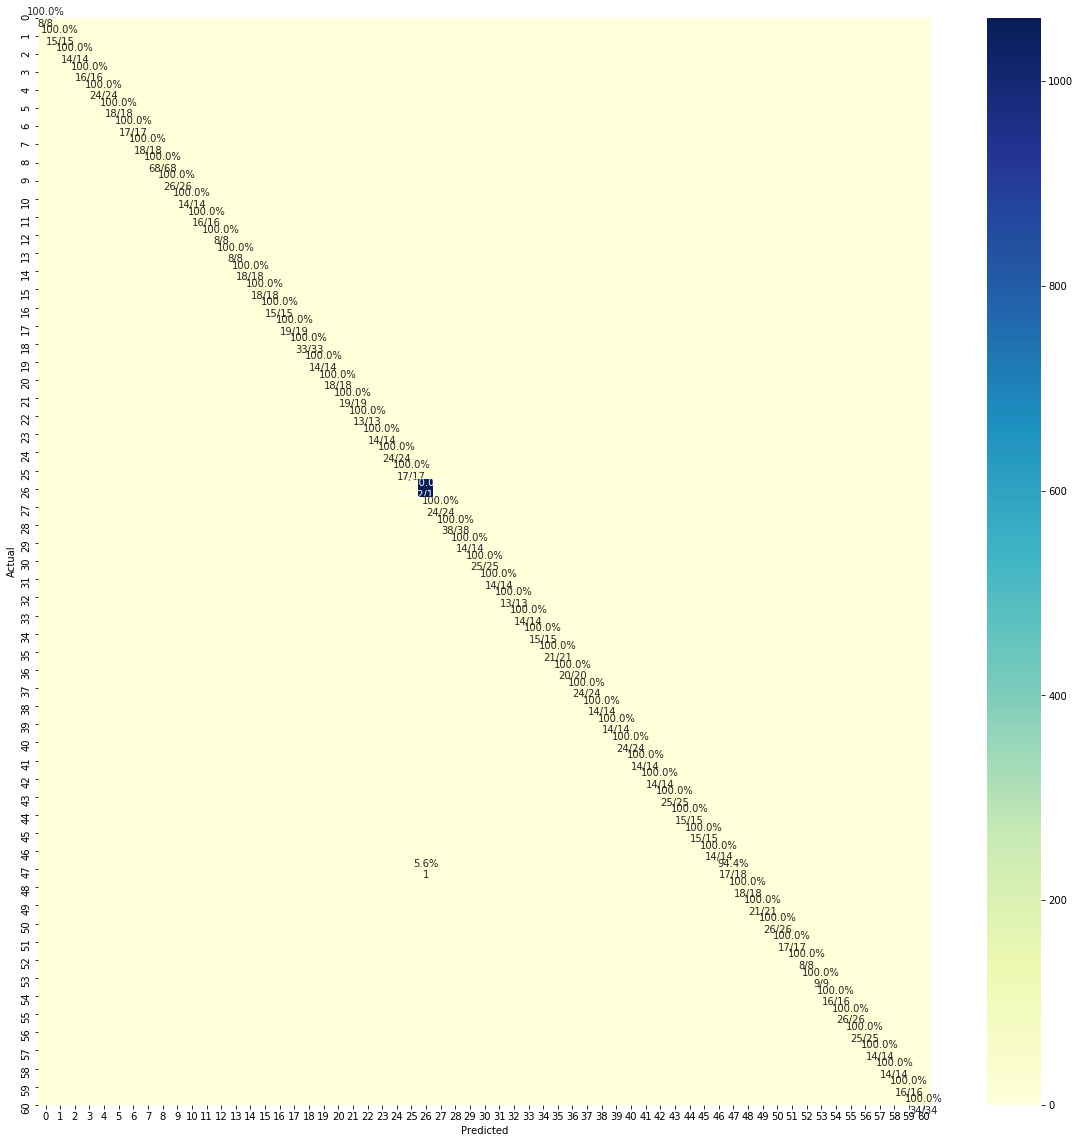

In [22]:
plot_cm(y_true=y_train, y_pred=train_pred)

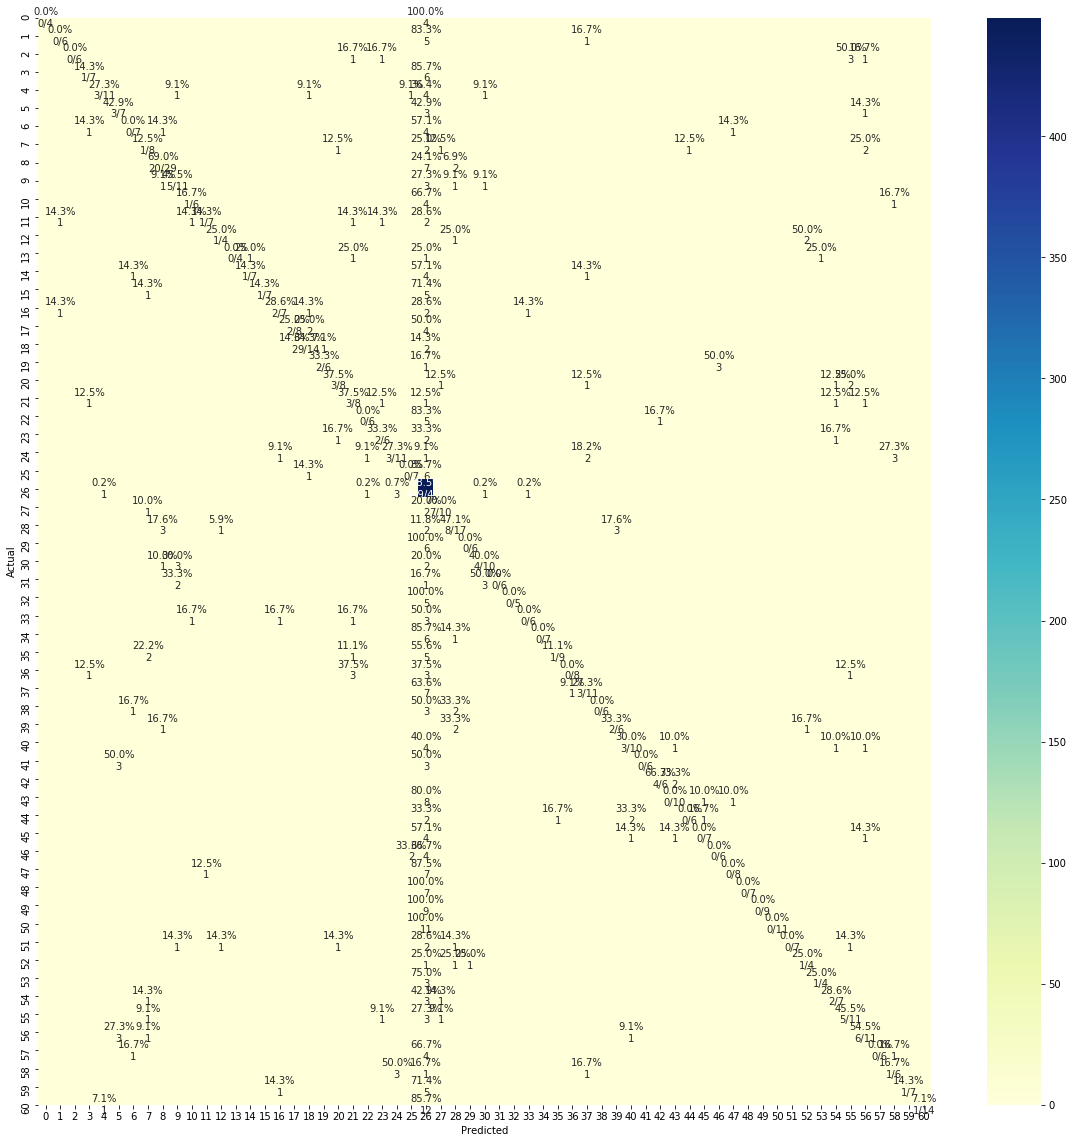

In [23]:
plot_cm(y_true=y_val, y_pred=val_pred)

# For Submit

In [49]:
def prerpocessing_using_static_submit(features_set):
    input_set = []
    
    for id_idx in range(features_set.id.min(), features_set.id.max()+1):
        sample_features = features_set[["acc_x","acc_y","acc_z"]][features_set.id==id_idx].values
        
        #Delete noise & principa component
        sample_features_cum = sample_features[0,:].reshape(1,3)
        for idx in range(1, sample_features.shape[0]):
            sample_features_cum = np.concatenate(
                                                 (sample_features_cum, (sample_features[:idx,:].sum(axis=0).reshape(1,3))
                                                 ), axis=0)
        
        principal_eigen_vector = (sample_features_cum[-1,:] - sample_features_cum[0,:]) / len(sample_features_cum)
        
        sample_features_cum_kl = sample_features_cum[0,:].reshape(1,3)
        for idx in range(1, sample_features_cum.shape[0]):
            sample_features_cum_kl = np.concatenate(
                                                    (sample_features_cum_kl,
                                                    (sample_features_cum[idx,:]-(principal_eigen_vector*idx)).reshape(1,3))
                                                   , axis=0)
        sample_features_cum_kl_mean = sample_features_cum_kl.mean(axis=0)
        sample_features_cum_kl_std = sample_features_cum_kl.std(axis=0)
        
        sample_features_cum_kl_norm = (sample_features_cum_kl-sample_features_cum_kl_mean) / sample_features_cum_kl_std

        #Transform to static
        #Mean values
        mean_arr = sample_features_cum_kl_norm.mean(axis=0)
        #Mag values
        mag_arr = abs(sample_features_cum_kl_norm).mean(axis=0)
        #Std values
        std_arr = sample_features_cum_kl_norm.std(axis=0)
        #Cov values
        cov_xy = np.cov(sample_features_cum_kl_norm[:,0], sample_features_cum_kl_norm[:,1])[0][1]
        cov_yz = np.cov(sample_features_cum_kl_norm[:,1], sample_features_cum_kl_norm[:,2])[0][1]
        cov_zx = np.cov(sample_features_cum_kl_norm[:,2], sample_features_cum_kl_norm[:,0])[0][1]
        #Corr values
        cor_xy = cov_xy / (std_arr[0]*std_arr[1])
        cor_yz = cov_yz / (std_arr[1]*std_arr[2])
        cor_zx = cov_zx / (std_arr[2]*std_arr[0])
        #Start End point change of vector values
        start_point = sample_features_cum_kl_norm[:3,:].mean(axis=0)
        end_point = sample_features_cum_kl_norm[-3:,:].mean(axis=0)
        change_of_vector_st = np.cos((start_point * end_point).sum() / (np.sqrt(np.power(start_point, 2).sum()) * np.sqrt(np.power(end_point, 2).sum())))
        #Energy values
        shift_0_values = np.roll(sample_features_cum_kl_norm, 1, axis=0)[1:]
        shift_1_values = sample_features_cum_kl_norm[1:]
        energy = np.power((shift_0_values-shift_1_values),2).mean(axis=0)
        #Max Min point num
        increase_shift_0 = np.where(shift_0_values-shift_1_values>=0, 1, -1)
        increase_shift_1 = np.roll(increase_shift_0, 1, axis=0)
        max_min_point_num = np.where(increase_shift_0[1:]*increase_shift_1[1:]==-1, 1, 0).sum(axis=0)
        
        id_sample_set = list(mean_arr) + list(mag_arr) + list(std_arr) + [cor_xy, cor_yz, cor_zx] + [change_of_vector_st] + list(energy) + list(max_min_point_num)
        
        #Append
        input_set.append(id_sample_set)
    
    input_set = np.array(input_set)
    print(input_set.shape)
    return input_set

In [50]:
test_input = prerpocessing_using_static_submit(features_set=test_features)

(782, 19)


In [51]:
test_pred = clf.predict(test_input)

In [52]:
result_df = pd.DataFrame()
result_df['id'] = sample_submissuib.id
for i in range(61):
    result_df[i] = test_pred[:,i]

In [53]:
result_df.to_csv("/works/Data/Dacon/health_data_clf/result/210211.csv",index=False)